# Regression on California Housing Dataset using Decision Trees

## Setup

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.tree import export_text

In [ ]:
np.random.seed(306)

Lets use ShuffleSplit as cv with 10 splits and 20% examples set aside as test examples


In [ ]:
cv = ShuffleSplit(n_splits = 10 ,test_size = 0.2, random_state = 42)

## Load the data

In [ ]:
features, labels  = fetch_california_housing(as_frame = True, return_X_y = True)

#train_test_split

com_train_features, test_features, com_train_labels, test_labels = train_test_split(features, labels , random_state = 42)


#train_dev_split

train_features, dev_featurs, train_labels, dev_labels = train_test_split(com_train_features, com_train_labels, random_state = 42)

In [ ]:
train_features.shape

(11610, 8)

In [ ]:
features.shape

(20640, 8)

In [ ]:
dt_reg_pipeline = Pipeline([('scaler', StandardScaler()),
                             ('dt_reg', DecisionTreeRegressor(max_depth = 3, random_state = 42))])


dt_reg_pipeline_cv = cross_validate(dt_reg_pipeline,
                                    train_features,
                                    train_labels,
                                    scoring = 'neg_mean_absolute_error',
                                    cv = cv,
                                    return_train_score = True,
                                    return_estimator =  True)

train_error = -1 * dt_reg_pipeline_cv['train_score']
test_error = -1 * dt_reg_pipeline_cv['test_score']

print('mean absolute error on training set', train_error.mean())
print('mean absolute error on test set', test_error.mean())

mean absolute error on training set 0.5889000822593158
mean absolute error on test set 0.5951802698999049


## Visualizing the tree

One of the advantages of using a decision tree classifier is that the output is intuitive to understand and can be easily visualised.

This can be done in two ways:
* As a tree diagram
* As a text based diagram


### 1. As a tree diagram

In [ ]:
dt_reg_pipeline.fit(train_features, train_labels)

Pipeline(steps=[('scaler', StandardScaler()),
                ('dt_reg',
                 DecisionTreeRegressor(max_depth=3, random_state=42))])

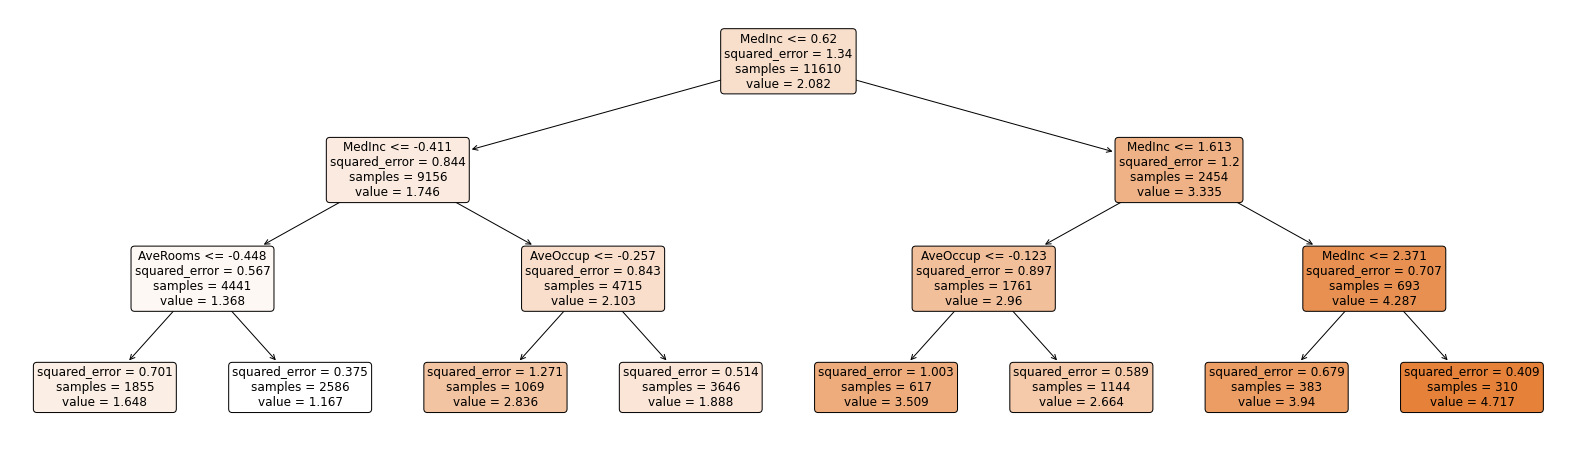

In [ ]:
plt.figure(figsize = (28,8), facecolor = 'w')
a = tree.plot_tree(dt_reg_pipeline[-1], 
                   feature_names = features.columns,
                   rounded = True,
                   filled = True,
                   fontsize = 12)

plt.show()

In [ ]:
features.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')

In [ ]:
labels.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

### 2. As text based diagram

In [ ]:
text_tree = export_text(dt_reg_pipeline[-1])

print(text_tree)

|--- feature_0 <= 0.62
|   |--- feature_0 <= -0.41
|   |   |--- feature_2 <= -0.45
|   |   |   |--- value: [1.65]
|   |   |--- feature_2 >  -0.45
|   |   |   |--- value: [1.17]
|   |--- feature_0 >  -0.41
|   |   |--- feature_5 <= -0.26
|   |   |   |--- value: [2.84]
|   |   |--- feature_5 >  -0.26
|   |   |   |--- value: [1.89]
|--- feature_0 >  0.62
|   |--- feature_0 <= 1.61
|   |   |--- feature_5 <= -0.12
|   |   |   |--- value: [3.51]
|   |   |--- feature_5 >  -0.12
|   |   |   |--- value: [2.66]
|   |--- feature_0 >  1.61
|   |   |--- feature_0 <= 2.37
|   |   |   |--- value: [3.94]
|   |   |--- feature_0 >  2.37
|   |   |   |--- value: [4.72]



## Using Tree for prediction

In [ ]:
pred = dt_reg_pipeline.predict(test_features)

## Evaluating the tree

In [ ]:
mse = mean_squared_error(test_labels, pred)
mae = mean_absolute_error(test_labels, pred)
r2  = r2_score(test_labels, pred)

print('mse',(mse))
print('mae', mae)
print('r2', r2)

mse 0.6417557936098145
mae 0.6005762942842664
r2 0.5150037690483743


Lets now try to improve the model by tuning hyperparameters

In [ ]:
 param_grid = { 'dt_reg__max_depth' : range(1,20),
              'dt_reg__min_samples_split': range(2,8)}

dt_grid_search  = GridSearchCV(dt_reg_pipeline,
                               param_grid = param_grid,
                               scoring = 'neg_mean_absolute_error',
                               n_jobs = 2,
                               cv = cv,
                               return_train_score = True)              

dt_grid_search.fit(com_train_features, com_train_labels)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('dt_reg',
                                        DecisionTreeRegressor(max_depth=3,
                                                              random_state=42))]),
             n_jobs=2,
             param_grid={'dt_reg__max_depth': range(1, 20),
                         'dt_reg__min_samples_split': range(2, 8)},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [ ]:
mean_train_error =-1 * dt_grid_search.cv_results_['mean_train_score'][dt_grid_search.best_index_] 
mean_test_error =-1 * dt_grid_search.cv_results_['mean_test_score'][dt_grid_search.best_index_] 
std_train_error =-1 * dt_grid_search.cv_results_['std_train_score'][dt_grid_search.best_index_] 
std_test_error =-1 * dt_grid_search.cv_results_['std_test_score'][dt_grid_search.best_index_] 

print(f"Best Mean absolute error of decision tree regression model on the train set: \n"
f"{mean_train_error:.3f} +/- {std_train_error:.3f}")
print(f"Best Mean absolute error of decision tree regression model on the test set: \n"
f"{mean_test_error:.3f} +/- {std_test_error:.3f}")


Best Mean absolute error of decision tree regression model on the train set: 
0.278 +/- -0.006
Best Mean absolute error of decision tree regression model on the test set: 
0.428 +/- -0.012


In [ ]:
dt_grid_search.best_params_

{'dt_reg__max_depth': 11, 'dt_reg__min_samples_split': 5}

In [ ]:
dt_reg_pipeline.set_params(dt_reg__max_depth = 11, dt_reg__min_samples_split = 5).fit(com_train_features, com_train_labels)


Pipeline(steps=[('scaler', StandardScaler()),
                ('dt_reg',
                 DecisionTreeRegressor(max_depth=11, min_samples_split=5,
                                       random_state=42))])

In [ ]:
test_labels_pred = dt_reg_pipeline.predict(test_features)
mae = mean_absolute_error(test_labels, test_labels_pred) 
mse = mean_squared_error(test_labels, test_labels_pred) 
r2 = r2_score(test_labels, test_labels_pred)

print("The model performance for testing set") 
print("---------------------------------------") 
print('MAE is',mae)
print('MSE is',mse)
print("R2 score is",r2)

The model performance for testing set
---------------------------------------
MAE is 0.4248952183820017
MSE is 0.4154957726373763
R2 score is 0.6859960039130073


#Decision Tree using pipeline

##Loading the dataset 
In this lecture, we will use the Abalone data set for classification.

Abalone is a type of consumable snail whose price varies as per its age. The aim is to predict the age of abalone from physical measurements.

The age of abalone is traditionally determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope-a boring and time-consuming task. Other measurements, which are easier to obtain, are used to predict the age.



In [ ]:
column_names = ['Sex', 'Length', 'Diameter', 'Height','Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']
abalone_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data', header = None, names =  column_names)

In [ ]:
abalone_data.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [ ]:
abalone_data.Rings.unique()

array([15,  7,  9, 10,  8, 20, 16, 19, 14, 11, 12, 18, 13,  5,  4,  6, 21,
       17, 22,  1,  3, 26, 23, 29,  2, 27, 25, 24])

Let's now see the type and name of the features:
 * **Sex**: The is the gender of the abalone and has categorical value (M,F or I) 
 * **Length**: The longest measurement of the abalone shell in mm. Continuous numeric value.
 * **Diameter**: The measurement of the abalone shell perpendicular to lenght in mm. Continuous numeric value.
 * **Height**: Height of the shell in mm. Continuous numeric value.
 * **Whole Weight**: Weight of the abalone in grams. Continous numeric value.
 * **Shucked Weight**: Weight of just the meat in abalone in grams. Continuous numeric value.
 * **Viscera Weight**: Weight of the abalone after bleeding in grams. Continuous numeric value.
 * **Shell Weight**: Weight of the abalone after being dried in grams. Continuous numeric value.
 * **Rings**: This is the target, that is the feature that we will train the model to predict. As mentioned earlier, we are interested in the age of the abalone and it has been established that number of rings + 1.5 gives the age. Discrete numeric value.

In [ ]:
type(abalone_data)

pandas.core.frame.DataFrame

In [ ]:
abalone_data.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


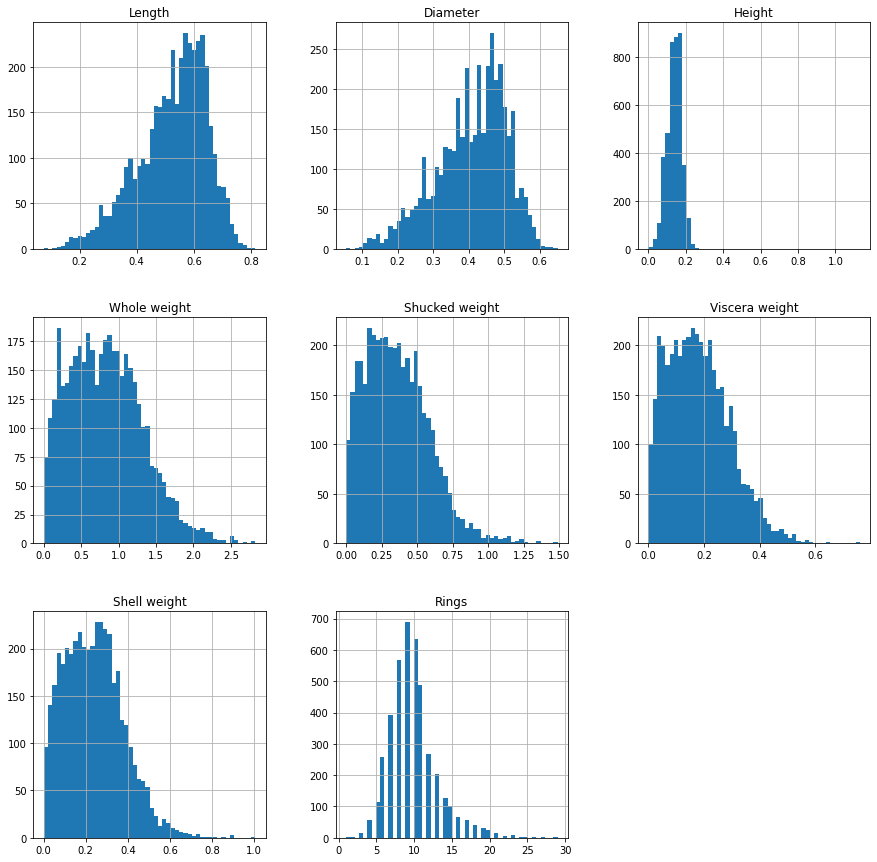

In [ ]:
abalone_data.hist(bins = 50, figsize = (15,15))
plt.show()

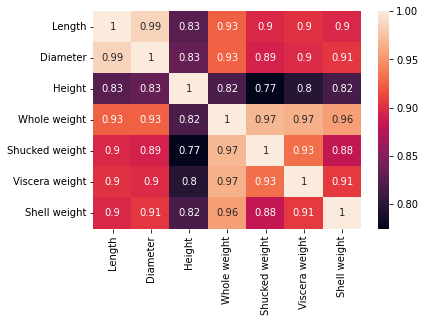

In [ ]:
plt.figure()
sns.heatmap(abalone_data.iloc[:,:-1].corr() , annot = True , square = False)
plt.show()

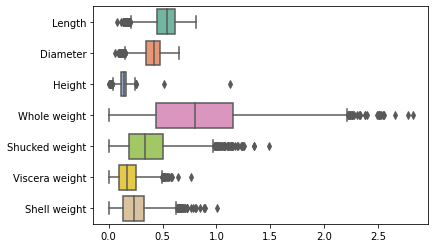

In [ ]:
plt.figure()
sns.boxplot(data = abalone_data.iloc[:,:-1], orient = 'h', palette = 'Set2')
plt.show()

In [ ]:
abalone_data.describe()

,Sex,Length,Diameter,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


The count row shows that they are no missing values. However, in the height feature the missing value is zero.This possibly calls for a missing value in the heights column and we will deal with the missing value in preprocessing step

## Missing values count

In [ ]:
(abalone_data['Height'] == 0).sum()

2

In [ ]:
abalone_data[abalone_data['Height'] == 0]

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
1257,I,0.430,0.34,0.0,0.428,0.2065,0.0860,0.1150,8
3996,I,0.315,0.23,0.0,0.134,0.0575,0.0285,0.3505,6


## Storing the data in the form of X and y

In [ ]:
X = abalone_data.iloc[:,:-1] #features
y = abalone_data.iloc[:,-1] # target


In [ ]:
# Spliting the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size = 0.2, random_state = 0)

## Piplining

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier


Identify numeric and categorical Features

In [ ]:
numeric_features = ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight']
categorical_features = ['Sex']

In [ ]:
#creating numeric transformer
numeric_transformer = Pipeline(steps = [('imputer', SimpleImputer(missing_values = 0, strategy = 'constant', fill_value= 0.107996)),
                                        ('scaler', StandardScaler())])

In [ ]:
#creating categorical transformer
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [ ]:
preprocess = ColumnTransformer(
    transformers= [('num', numeric_transformer, numeric_features),
                   ('cat', categorical_transformer, categorical_features)]
)

In [ ]:
clf = Pipeline(
    steps = [('preprocess', preprocess),
             ('classifier', DecisionTreeClassifier(max_depth = 3, 
                                                   random_state =42))]
)

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0.107996,
                                                                                 missing_values=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Length', 'Diameter',
                                                   'Height', 'Whole weight',
                                                   'Shucked weight',
                                                   'Viscera weight',
                                                   'Shell weight']),
       

In [ ]:
clf.score(X_test, y_test)

0.2452153110047847

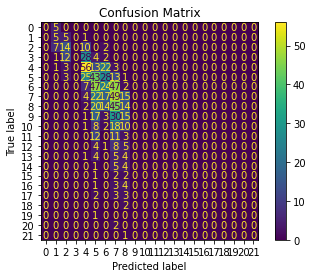

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
#visualizing confusion matrix 
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.26      0.45      0.33        11
           5       0.38      0.42      0.40        33
           6       0.00      0.00      0.00        47
           7       0.41      0.57      0.48        98
           8       0.21      0.38      0.27       113
           9       0.21      0.19      0.20       127
          10       0.20      0.46      0.28       107
          11       0.16      0.15      0.16        95
          12       0.00      0.00      0.00        66
          13       0.00      0.00      0.00        39
          14       0.00      0.00      0.00        26
          15       0.00      0.00      0.00        18
          16       0.00      0.00      0.00        14
          17       0.00      0.00      0.00        10
          18       0.00      0.00      0.00         5
          19       0.00      0.00      0.00         8
          20       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(cm)

[[ 0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  5  5  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  7 14  0 10  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1 12  0 28  4  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  3  0 56 13 22  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  3  0 25 43 28 13  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  7 47 24 47  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  4 22 17 49 15  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2 20 14 45 14  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1 17  3 30 15  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  8  2 18 10  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 12  0 11  3  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  4  1  8  5  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  4  0  5  4  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  5  4  0  0

## Cross validation

In [ ]:
clf_cv = cross_val_score(clf,
                        X_train,
                        y_train,
                        cv  = 10)
clf_cv.mean()

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  UserWarning,


0.25530699794440964

## Visualising the decision Tree


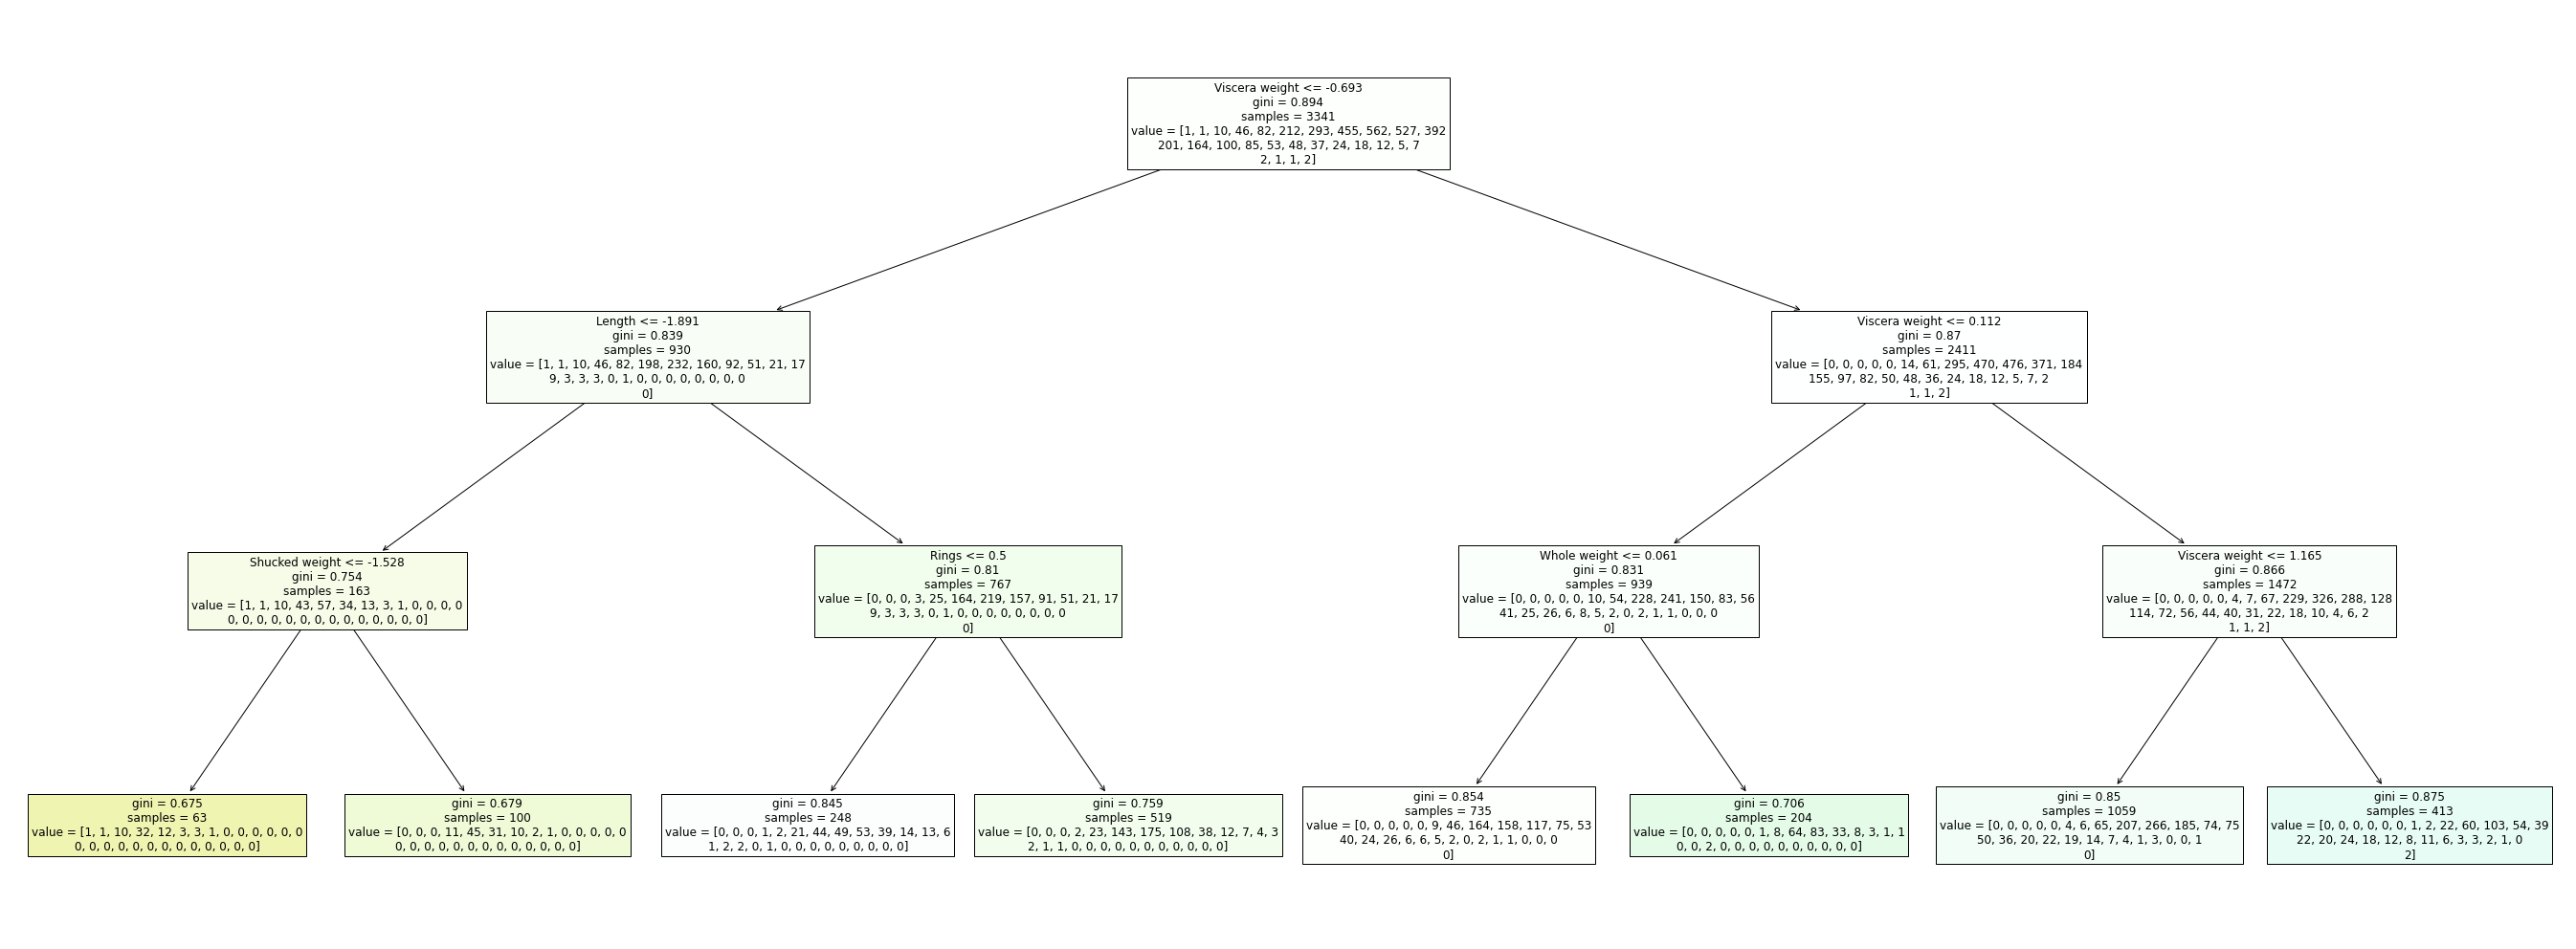

In [ ]:
from sklearn import tree
plt.figure(figsize = (48,18), facecolor = 'w')
a = tree.plot_tree(clf['classifier'],
              feature_names = column_names,
              filled = True,
              fontsize= 12)
plt.show()

## Tuning the hyperparameters

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'classifier__max_depth': [1,2,3,4,5,6,7,8,9],
              'classifier__min_samples_split':[2,4,6,8,10]}

clf_gridcv = GridSearchCV(clf,
                          param_grid = param_grid,
                          scoring = 'recall_macro',
                          )
clf_gridcv.fit(X_train, y_train)


In [ ]:
clf_gridcv.best_params_

{'classifier__max_depth': 5, 'classifier__min_samples_split': 10}

In [ ]:
clf.set_params(classifier__max_depth = 5 , classifier__min_samples_split = 10).fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0.107996,
                                                                                 missing_values=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Length', 'Diameter',
                                                   'Height', 'Whole weight',
                                                   'Shucked weight',
                                                   'Viscera weight',
                                                   'Shell weight']),
       